In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train = pd.read_csv("../data/processed/store_train.csv")
test  = pd.read_csv("../data/processed/store_test.csv")

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])


In [3]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train[['Sales']])
test_scaled  = scaler.transform(test[['Sales']])


In [4]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 14

X_train, y_train = create_sequences(train_scaled, WINDOW)
X_test,  y_test  = create_sequences(test_scaled, WINDOW)


In [5]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [6]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1158
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0360
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0370
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0376
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0356
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0354
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0351
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0369
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0368
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0316
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0354
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0371
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0399
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0350
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0296
Epoc

In [8]:
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


In [9]:
actual = test['Sales'].iloc[WINDOW:].values


In [10]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

lstm_mae, lstm_rmse, lstm_mape = evaluate(actual, lstm_pred)

lstm_mae, lstm_rmse, lstm_mape


(978.2149047851562,
 np.float64(1394.6439061638637),
 np.float64(26.25438365110999))

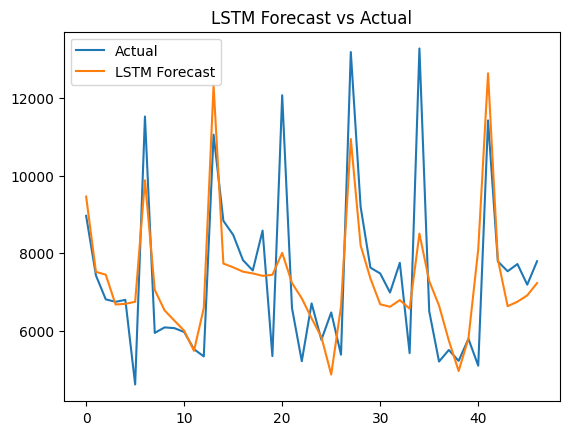

In [11]:
plt.figure()
plt.plot(actual, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()


In [12]:
lstm_results = pd.DataFrame({
    'Model': ['LSTM'],
    'MAE': [lstm_mae],
    'RMSE': [lstm_rmse],
    'MAPE': [lstm_mape]
})

lstm_results.to_csv(
    "../models/baseline/lstm_metrics.csv",
    index=False
)


### Phase 9 Summary — LSTM

An LSTM model was trained to capture non-linear temporal dependencies in sales data.
Despite its flexibility, performance gains over classical models were limited, highlighting that model complexity does not always guarantee superior forecasts for structured retail time series.
